# Sentiment Analysis tutorial
Real Python [Tutorial](https://realpython.com/python-keras-text-classification/)

Data taken from [here](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences#)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn')

from zipfile import ZipFile

In [2]:
path = 'C:/Users/Javi/00_raw_data/sentiment labelled sentences.zip'

In [3]:
zfile = ZipFile(path)
len(zfile.filelist)

12

In [4]:
# We are only interested in items 5, 6, 10. All of them txt files
our_files = {5: 'Amazon', 6: 'IMDB', 10: 'Yelp'}
columns = ['sentence', 'label']
dfs = []

for index, source in our_files.items():
    
    csv = zfile.open(zfile.filelist[index])
    df = pd.read_csv(csv, names=columns, sep='\t')
    df['source'] = source
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

In [5]:
print(data.shape)
data.head()

(2748, 3)


,sentence,label,source
0,So there is no way for me to plug it in here i...,0,Amazon
1,"Good case, Excellent value.",1,Amazon
2,Great for the jawbone.,1,Amazon
3,Tied to charger for conversations lasting more...,0,Amazon
4,The mic is great.,1,Amazon


### How NLP works
**Corpus:** The collection of texts.<br>
**Vocabulary:** A list of words that occurred in our whole *corpus* where each word has its own index.<br>
**Feature vector:** Represents a comment (text). It has the length of the vocabulary containing 1s & 0s.<br>
**Bag of words (BOW):** All the vectors.

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

In [7]:
# Let's see a simple example

comments = ['John likes ice cream', 'John hates chocolate']

vectorizer = CountVectorizer(min_df=0, lowercase=False)
vectorizer.fit(comments)
vectorizer.vocabulary_

{'John': 0, 'likes': 5, 'ice': 4, 'cream': 2, 'hates': 3, 'chocolate': 1}

In [8]:
vectorizer.transform(comments).toarray()

array([[1, 0, 1, 0, 1, 1],
       [1, 1, 0, 1, 0, 0]], dtype=int64)

### Baseline model
Using `Scikit-Learn` *CountVectorizer*

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
yelp = data[data['source'] == 'Yelp']

In [11]:
comments = yelp['sentence'].values
y = yelp['label'].values

In [12]:
comments_train, comments_test, y_train, y_test = train_test_split(comments, y)

In [13]:
type(comments_train), comments_train.shape

(numpy.ndarray, (750,))

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(comments_train)

X_train = vectorizer.transform(comments_train)
X_test = vectorizer.transform(comments_test)

In [15]:
X_train

<750x1739 sparse matrix of type '<class 'numpy.int64'>'
	with 7273 stored elements in Compressed Sparse Row format>

In [16]:
len(vectorizer.vocabulary_)

1739

In [17]:
X_train.toarray().shape

(750, 1739)

`CountVectorizer` performs tokenization which separates the sentences into a set of **tokens** as you saw previously in the vocabulary. It additionally removes punctuation and special characters and can apply other preprocessing to each word. If you want, you can use a custom tokenizer from the [NLTK](https://realpython.com/python-nltk-sentiment-analysis/) library with the *CountVectorizer* or use any number of the customizations which you can explore to improve the performance of your model (specify *StopWords*, etc).

### Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression().fit(X_train, y_train)
# Accuracy
classifier.score(X_train, y_train), classifier.score(X_test, y_test)

(0.988, 0.812)

Let's make a script that iterate over each DataFrame and gets accuracy LogisticRegressor scores for us.

In [43]:
def log_reg():
    # Iterates over each source
    for source in data['source'].unique():
        # Preparing sets
        df = data[data['source'] == source]
        comments = df['sentence'].values
        y = df['label'].values
        # Splits
        comments_train, comments_test, y_train, y_test = train_test_split(comments, y, random_state=42)
        # Tokenizing sets
        vectorizer = CountVectorizer()
        vectorizer.fit(comments_train)
        X_train = vectorizer.transform(comments_train)
        X_test = vectorizer.transform(comments_test)
        # Training the model
        classifier = LogisticRegression().fit(X_train, y_train)
        # Printing the score (accuracy)
        print(source)
        print(f'\tTrain Score: {round(classifier.score(X_train, y_train), 3)}')
        print(f'\tTest Score: {round(classifier.score(X_test, y_test), 3)}')

In [44]:
log_reg()

Amazon
	Train Score: 0.996
	Test Score: 0.844
IMDB
	Train Score: 0.991
	Test Score: 0.727
Yelp
	Train Score: 0.991
	Test Score: 0.816


### Naive Bayes
This classifier is widely used in Sentiment Analysis. Let's see if we can get a higher score.

In [38]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB

In [45]:
def naive_bayes():
    # Iterates over each source
    for source in data['source'].unique():
        # Preparing sets
        df = data[data['source'] == source]
        comments = df['sentence'].values
        y = df['label'].values
        # Splits
        comments_train, comments_test, y_train, y_test = train_test_split(comments, y, random_state=42)
        # Tokenizing sets
        vectorizer = CountVectorizer()
        vectorizer.fit(comments_train)
        X_train = vectorizer.transform(comments_train)
        X_test = vectorizer.transform(comments_test)
        # Training the model
        classifier = MultinomialNB().fit(X_train, y_train)
        # Printing the score (accuracy)
        print(source)
        print(f'\tTrain Score: {round(classifier.score(X_train, y_train), 3)}')
        print(f'\tTest Score: {round(classifier.score(X_test, y_test), 3)}')

In [46]:
naive_bayes()

Amazon
	Train Score: 0.969
	Test Score: 0.84
IMDB
	Train Score: 0.975
	Test Score: 0.743
Yelp
	Train Score: 0.955
	Test Score: 0.804


### Deep Learning

In [47]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

In [50]:
from tensorflow.keras.backend import clear_session
clear_session()

In [51]:
# Number of features
input_shape = X_train[0].shape[1]

model = models.Sequential()

model.add(Input(shape=input_shape))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [54]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                17180     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 17,191
Trainable params: 17,191
Non-trainable params: 0
_________________________________________________________________


Since the training in neural networks is an iterative process, the training won’t just stop after it is done. You have to specify the number of iterations you want the model to be training. Those completed iterations are commonly called **epochs**. We want to run it for 100 epochs to be able to see how the training loss and accuracy are changing after each epoch.

Another parameter you have to your selection is the batch size. The **batch size** is responsible for how many samples we want to use in one epoch, which means how many samples are used in one forward/backward pass. This increases the speed of the computation as it need fewer epochs to run, but it also needs more memory, and the model may degrade with larger batch sizes. Since we have a small training set, we can leave this to a low batch size.

In [55]:
# Train the model
history = model.fit(X_train.toarray(), y_train, epochs=20, batch_size=10, validation_split=0.1)

Train on 675 samples, validate on 75 samples
Epoch 1/20
675/675 [==============================] - 0s 563us/sample - loss: 0.6868 - acc: 0.5867 - val_loss: 0.6714 - val_acc: 0.7067
Epoch 2/20
675/675 [==============================] - 0s 209us/sample - loss: 0.6348 - acc: 0.7896 - val_loss: 0.6206 - val_acc: 0.8133
Epoch 3/20
675/675 [==============================] - 0s 214us/sample - loss: 0.5434 - acc: 0.8622 - val_loss: 0.5602 - val_acc: 0.8400
Epoch 4/20
675/675 [==============================] - 0s 221us/sample - loss: 0.4379 - acc: 0.9111 - val_loss: 0.5047 - val_acc: 0.8533
Epoch 5/20
675/675 [==============================] - 0s 269us/sample - loss: 0.3467 - acc: 0.9467 - val_loss: 0.4647 - val_acc: 0.8667
Epoch 6/20
675/675 [==============================] - 0s 233us/sample - loss: 0.2763 - acc: 0.9615 - val_loss: 0.4288 - val_acc: 0.8933
Epoch 7/20
675/675 [==============================] - 0s 272us/sample - loss: 0.2224 - acc: 0.9763 - val_loss: 0.4020 - val_acc: 0.8933
Epo

In [56]:
loss, accuracy = model.evaluate(X_test, y_test)
loss, accuracy

250/250 [==============================] - 0s 34us/sample - loss: 0.4954 - acc: 0.7920


(0.4953701300621033, 0.792)

In [57]:
type(history)

tensorflow.python.keras.callbacks.History

In [58]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'r', label='Training acc')
    plt.plot(x, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'r', label='Training loss')
    plt.plot(x, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

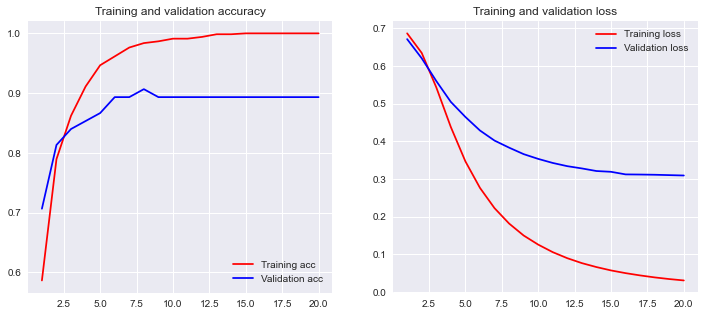

In [59]:
plot_history(history)

A good way to see when the model starts overfitting is when the loss of the validation data starts rising again. This tends to be a good point to stop the model.

**Note:** When training neural networks, you should use a separate testing and validation set. What you would usually do is take the model with the highest validation accuracy and then test the model with the testing set.

This makes sure that you don’t overfit the model. Using the validation set to choose the best model is a form of data leakage (or “cheating”) to get to pick the result that produced the best test score out of hundreds of them. Data leakage happens when information outside the training data set is used in the model.

### Word Embedding
Using `TensorFlow` *Tokenizer*

In [60]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(comments_train)

X_train = tokenizer.texts_to_sequences(comments_train)
X_test = tokenizer.texts_to_sequences(comments_test)

In [63]:
# Each vector from X_train contains integers and it's the same length as the original comment
# Those integers represent indexes from "tokenizer.word_index",  which is our dictionary
print(comments_train[2])
print(X_train[2])

This is a GREAT place to eat!
[8, 7, 5, 23, 15, 6, 97]


In [68]:
print(len(tokenizer.word_index))
tokenizer.word_index

1748


{'the': 1,
 'and': 2,
 'i': 3,
 'was': 4,
 'a': 5,
 'to': 6,
 'is': 7,
 'this': 8,
 'it': 9,
 'of': 10,
 'food': 11,
 'not': 12,
 'for': 13,
 'good': 14,
 'place': 15,
 'in': 16,
 'service': 17,
 'very': 18,
 'with': 19,
 'that': 20,
 'we': 21,
 'my': 22,
 'great': 23,
 'but': 24,
 'so': 25,
 'have': 26,
 'were': 27,
 'had': 28,
 'are': 29,
 'they': 30,
 'you': 31,
 'back': 32,
 'be': 33,
 'on': 34,
 'at': 35,
 'all': 36,
 'here': 37,
 'go': 38,
 'as': 39,
 'there': 40,
 'like': 41,
 'our': 42,
 'really': 43,
 'if': 44,
 'will': 45,
 'time': 46,
 'their': 47,
 'ever': 48,
 'friendly': 49,
 'would': 50,
 'restaurant': 51,
 'just': 52,
 "don't": 53,
 'one': 54,
 'out': 55,
 'also': 56,
 'best': 57,
 'from': 58,
 'only': 59,
 'never': 60,
 'an': 61,
 'amazing': 62,
 'up': 63,
 'pretty': 64,
 'delicious': 65,
 'some': 66,
 'what': 67,
 'been': 68,
 'no': 69,
 'again': 70,
 'did': 71,
 'nice': 72,
 'which': 73,
 "i've": 74,
 'by': 75,
 "i'm": 76,
 'definitely': 77,
 'get': 78,
 'your': 79,


**Note:** Pay close attention to the difference between this technique and the X_train that was produced by scikit-learn’s CountVectorizer.

With CountVectorizer, we had stacked vectors of word counts, and each vector was the same length (the size of the total corpus vocabulary). With Tokenizer, the resulting vectors equal the length of each text, and the numbers don’t denote counts, but rather correspond to the word values from the dictionary tokenizer.word_index.

One problem that we have is that **each text** sequence **has different length of words**. To counter this, you can use `pad_sequence` which simply pads the sequence of words with zeros. By default, it prepends zeros but we want to append them. Typically it does not matter whether you prepend or append zeros.

In [70]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [84]:
vocab_size = len(tokenizer.word_index) + 1   # Adding 1 because it starts with 0
max_words = 10000
max_len = 100   # maximum length of the reviews
embedding_dim = 50   # number of components of the embedding vector

In [74]:
X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

In [81]:
print(len(X_train[2]))
X_train[2]

100


array([ 8,  7,  5, 23, 15,  6, 97,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [92]:
clear_session()

In [93]:
model = models.Sequential()

model.add(layers.Embedding(input_dim=vocab_size,
                           output_dim=embedding_dim,
                           input_length=max_len))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [94]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 50)           87450     
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                50010     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 137,471
Trainable params: 137,471
Non-trainable params: 0
_________________________________________________________________


In [95]:
history = model.fit(X_train, y_train, epochs=20, batch_size=10, validation_split=0.1)

Train on 675 samples, validate on 75 samples
Epoch 1/20
675/675 [==============================] - 0s 671us/sample - loss: 0.6936 - acc: 0.4815 - val_loss: 0.6931 - val_acc: 0.5467
Epoch 2/20
675/675 [==============================] - 0s 325us/sample - loss: 0.6932 - acc: 0.4948 - val_loss: 0.6933 - val_acc: 0.4533
Epoch 3/20
675/675 [==============================] - 0s 346us/sample - loss: 0.6932 - acc: 0.5037 - val_loss: 0.6933 - val_acc: 0.4533
Epoch 4/20
675/675 [==============================] - 0s 288us/sample - loss: 0.6931 - acc: 0.5037 - val_loss: 0.6935 - val_acc: 0.4533
Epoch 5/20
675/675 [==============================] - 0s 319us/sample - loss: 0.6932 - acc: 0.5037 - val_loss: 0.6935 - val_acc: 0.4533
Epoch 6/20
675/675 [==============================] - 0s 331us/sample - loss: 0.6932 - acc: 0.5037 - val_loss: 0.6934 - val_acc: 0.4533
Epoch 7/20
675/675 [==============================] - 0s 320us/sample - loss: 0.6932 - acc: 0.5037 - val_loss: 0.6938 - val_acc: 0.4533
Epo

In [97]:
loss, acc = model.evaluate(X_test, y_test)
loss, acc

250/250 [==============================] - 0s 67us/sample - loss: 0.6931 - acc: 0.5040


(0.6931154150962829, 0.504)

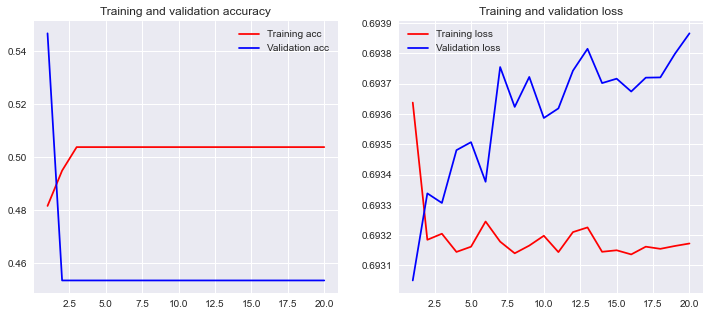

In [98]:
plot_history(history)

In [1]:
# Really bad result. Probably due to the short size of our data sets.